In [109]:
import torch
import torchvision
from torchvision import transforms as transforms
import torch.nn.functional as F
import torch.nn as nn
from torch.utils.data import DataLoader
import torch.optim as optim
import numpy as np
import cv2
import matplotlib.pyplot as plt

In [110]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(device)

cuda


In [111]:
trainset = torchvision.datasets.MNIST('data', download=True, train=True, transform=transforms.ToTensor())
train_loader = DataLoader(dataset=trainset, batch_size=128, shuffle=True)

In [112]:
10 // 3

3

In [113]:
class Flatten(nn.Module):
    def forward(self, x):
        batch_size = x.shape[0]

        return x.view(batch_size, -1)
    
class DeFlatten(nn.Module):
    def __init__(self, k) -> None:
        super().__init__()
        self.k = k

    def forward(self, x):
        batch_size, vector_size = x.size()
        feature_size = int((vector_size // self.k) ** 0.5)

        return x.view(batch_size, self.k, feature_size, feature_size)

In [114]:
class Autoencoder(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        
        k = 16
        self.encoder = nn.Sequential(
            nn.Conv2d(1, k, 3, stride=2),
            nn.ReLU(),
            nn.Conv2d(k, 2 * k, 3, stride=2),
            nn.ReLU(),
            nn.Conv2d(2 * k, 4 * k, 3, stride=1),
            nn.ReLU(),
            Flatten(),
            nn.Linear(1024, 10),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Linear(10, 1024),
            nn.ReLU(),
            DeFlatten(4 * k),
            nn.ConvTranspose2d(4 * k, 2 * k, 3, stride=1),
            nn.ReLU(),
            nn.ConvTranspose2d(2 * k, k, 3, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(k, 1, 3, stride=2, output_padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)

        return decoded

In [115]:
model = Autoencoder().to(device)

In [116]:
def normalize_output(img):
    img = (img - img.min() / img.max() - img.min())

    return img

In [117]:
def check_plot():
    model.eval()
    with torch.inference_mode():
        for images, _ in train_loader:
            inputs = images.to(device)
            outputs = model(inputs)
            
            input_samples = inputs.permute(0, 2, 3, 1).cpu().numpy()
            reconstructed_samples = outputs.permute(0, 2, 3, 1).cpu().numpy()
        
            break
        
        # input_samples = normalize_output(input_samples)
        # reconstructed_samples = normalize_output(reconstructed_samples)

        columns = 10
        rows = 5
        fig = plt.figure(figsize=(columns, rows))
        for i in range(1, columns * rows + 1):
            img = input_samples[i-1]
            fig.add_subplot(rows, columns, i)
            plt.imshow(img.squeeze())
            plt.axis('off')
        plt.show()

        fig = plt.figure(figsize=(columns, rows))
        for i in range(1, columns * rows + 1):
            img = reconstructed_samples[i-1]
            fig.add_subplot(rows, columns, i)
            plt.imshow(img.squeeze())
            plt.axis('off')
        plt.show()


In [118]:
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

[1 loss: 0.108]


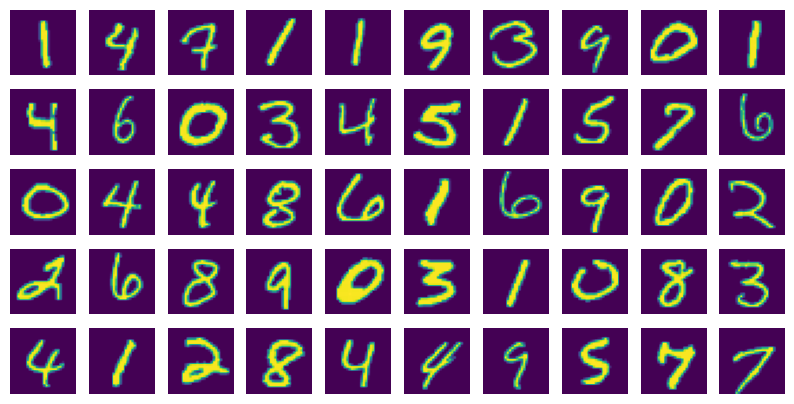

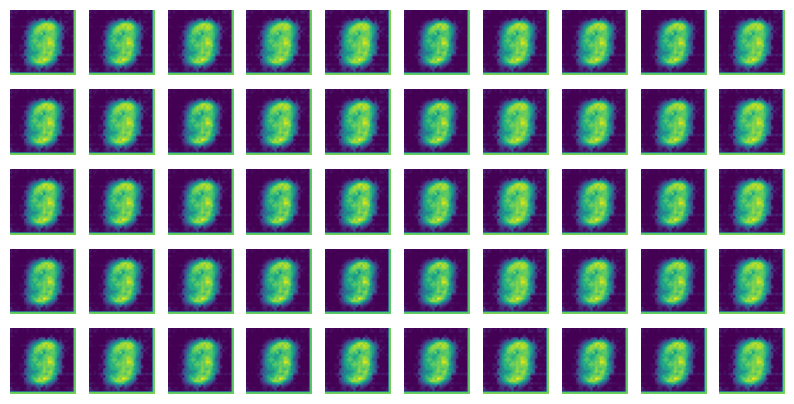

[11 loss: 0.037]


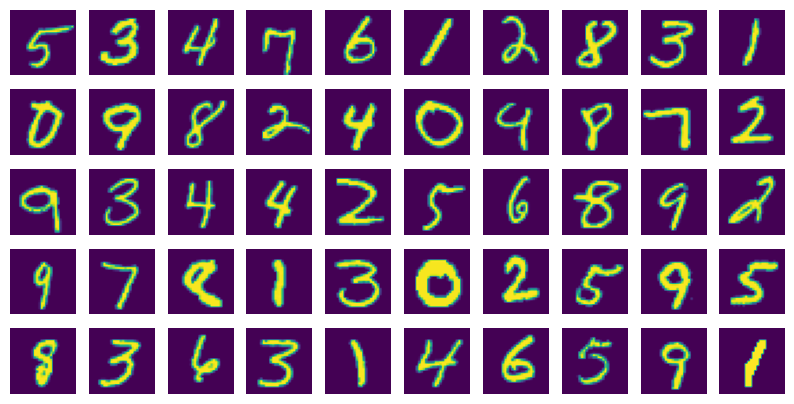

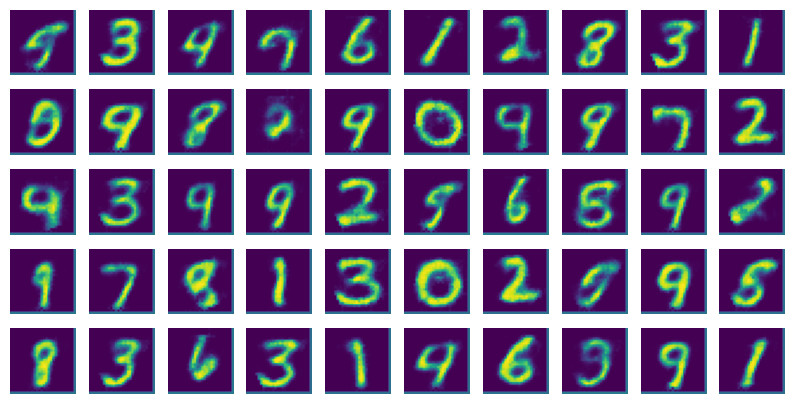

[21 loss: 0.029]


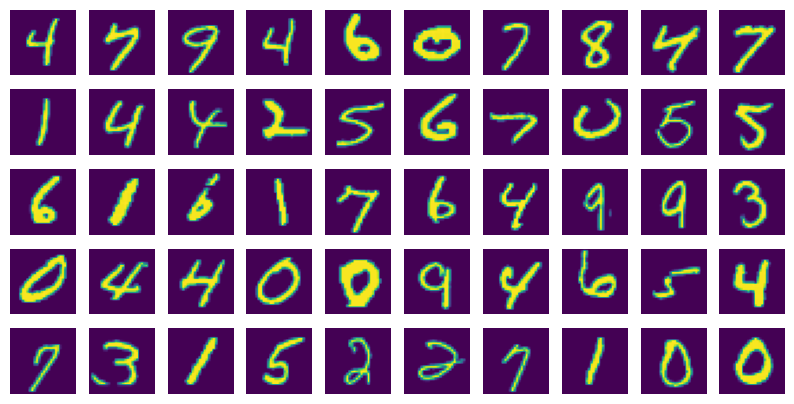

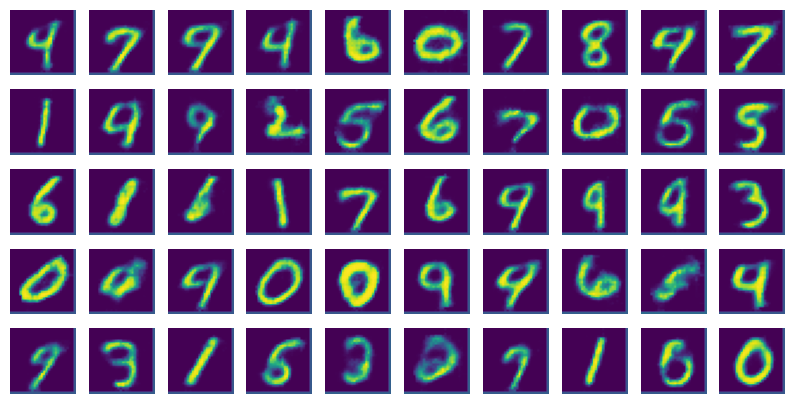

[31 loss: 0.025]


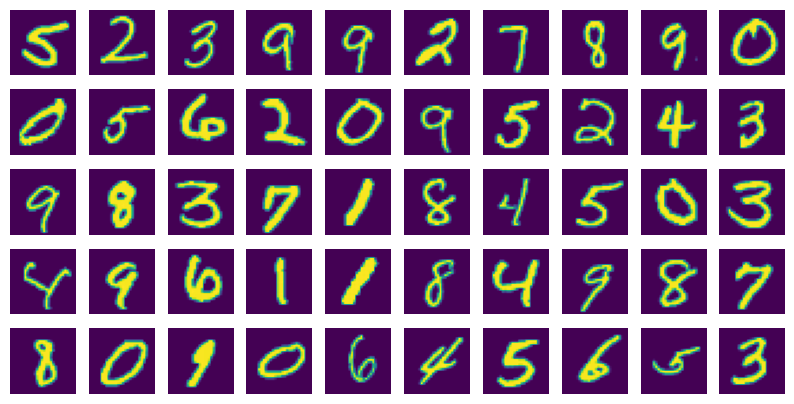

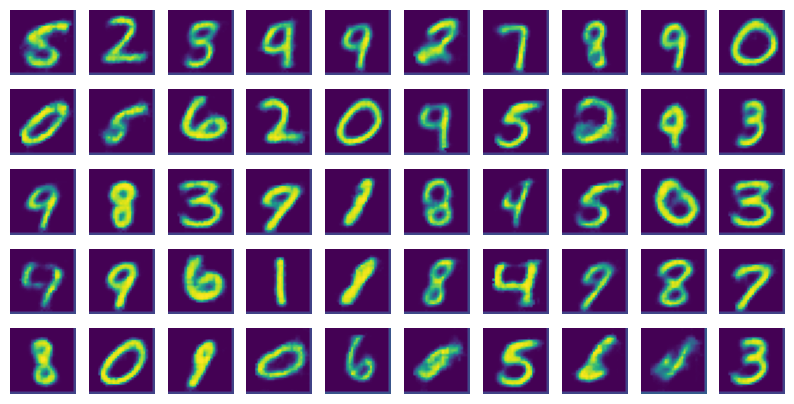

[41 loss: 0.023]


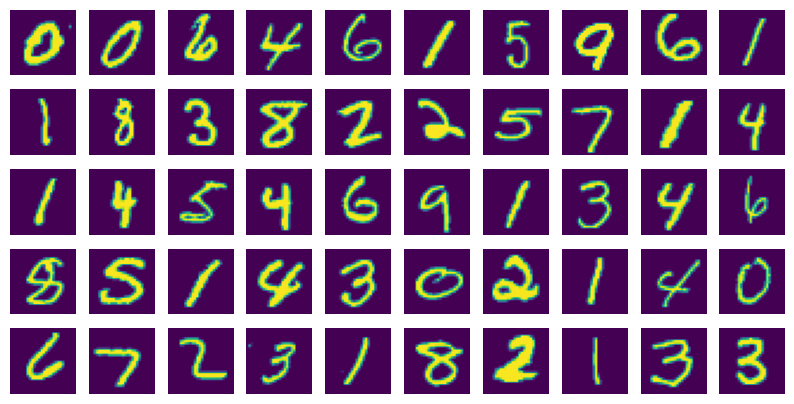

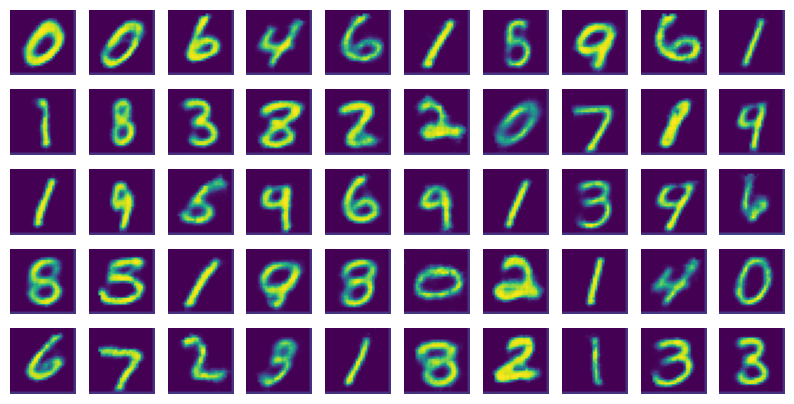

In [119]:
epochs = 41
for epoch in range(epochs):
    running_loss = 0.0
    for i, (inputs, labels) in enumerate(train_loader):
        inputs = inputs.to(device)
        outputs = model(inputs)
        loss = criterion(inputs, outputs)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        running_loss += loss

    cost = running_loss / len(train_loader)

    if epoch % 10 == 0:
        print(f'[{epoch + 1} loss: {cost:.3f}]')
        check_plot()